In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap
import os
    
# 1) load data: either from CSV exported from vw_employee_master OR via direct DB connection
df = pd.read_csv('vw_task1.csv')

# --- 3. Data Cleaning Sederhana ---
# Standardisasi data teks yang mungkin berantakan
df['disc'] = df['disc'].str.upper().str.strip()
df['mbti'] = df['mbti'].str.upper().str.strip()

# --- 4. Konfigurasi Visualisasi ---
sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use('seaborn-v0_8-whitegrid')

Failed to connect: connection to server at "localhost" (::1), port 5432 failed: fe_sendauth: no password supplied



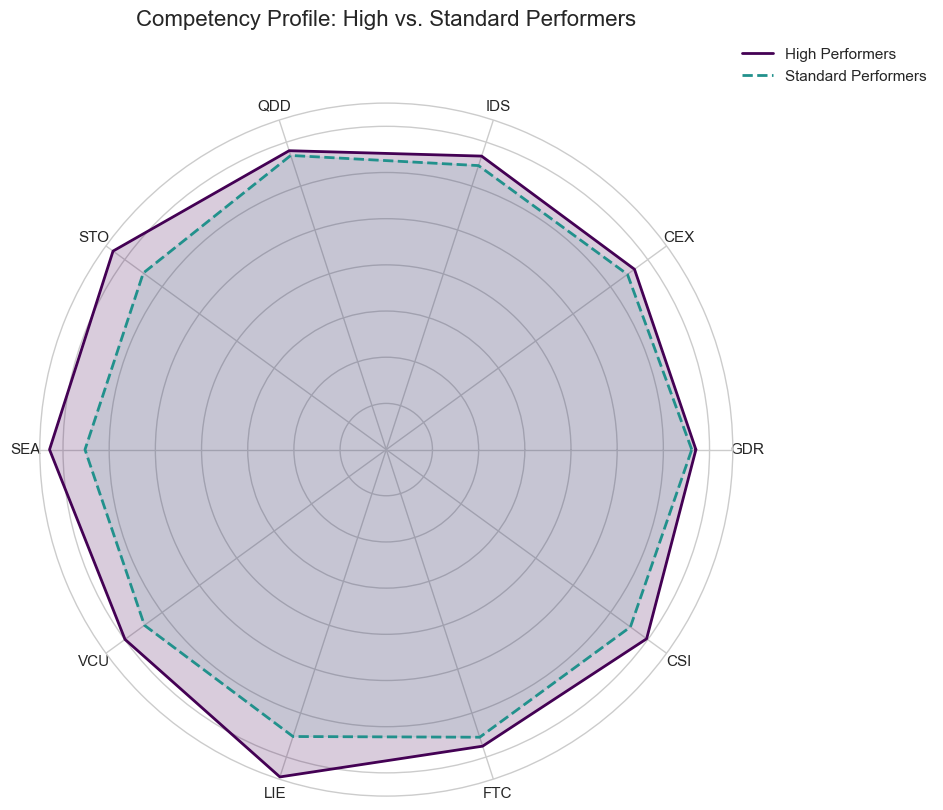

In [7]:
def plot_competency_radar(df):
    """Membuat radar chart untuk membandingkan profil kompetensi RATA-RATA."""
    # Sesuaikan nama kolom di sini
    competency_cols = [
        'gdr_score_avg', 'cex_score_avg', 'ids_score_avg', 'qdd_score_avg', 'sto_score_avg',
        'sea_score_avg', 'vcu_score_avg', 'lie_score_avg', 'ftc_score_avg', 'csi_score_avg'
    ]
    # Label bisa tetap sama
    labels = [col.replace('_score_avg', '').upper() for col in competency_cols]
    
    # Hitung rata-rata skor per grup, tangani missing values
    stats = df.groupby('performance_group')[competency_cols].mean()
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1] # Tutup lingkaran
    
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    
    # Plot High Performers
    values_hp = stats.loc['High Performer'].tolist()
    values_hp += values_hp[:1]
    ax.plot(angles, values_hp, color='#440154', linewidth=2, linestyle='solid', label='High Performers')
    ax.fill(angles, values_hp, color='#440154', alpha=0.2)
    
    # Plot Standard Performers
    values_sp = stats.loc['Standard Performer'].tolist()
    values_sp += values_sp[:1]
    ax.plot(angles, values_sp, color='#21918c', linewidth=2, linestyle='dashed', label='Standard Performers')
    ax.fill(angles, values_sp, color='#21918c', alpha=0.1)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=11)
    plt.title('Competency Profile: High vs. Standard Performers', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_competency_radar(df)

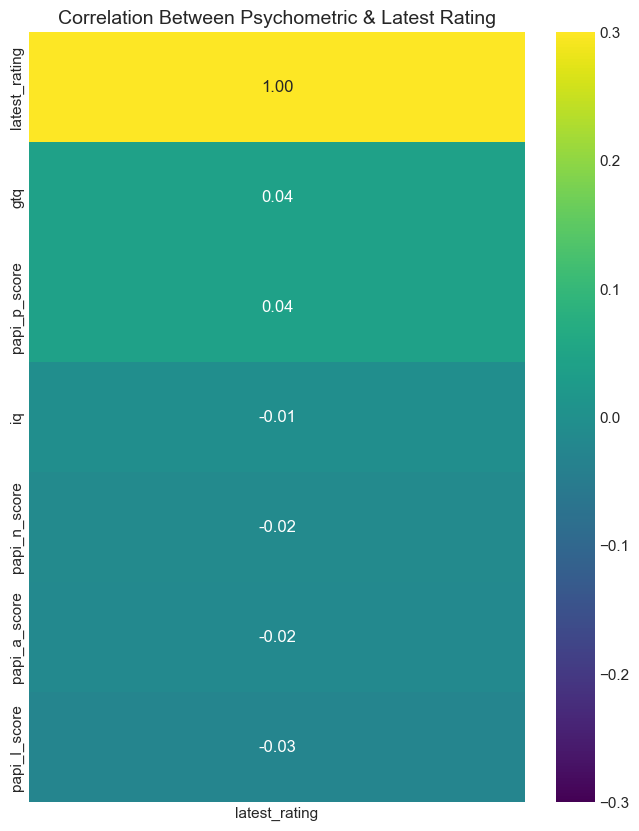

C:\Users\backup\AppData\Local\Temp\ipykernel_3476\2864827176.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disc_prop[disc_prop['performance_group'] == 'High Performer'],


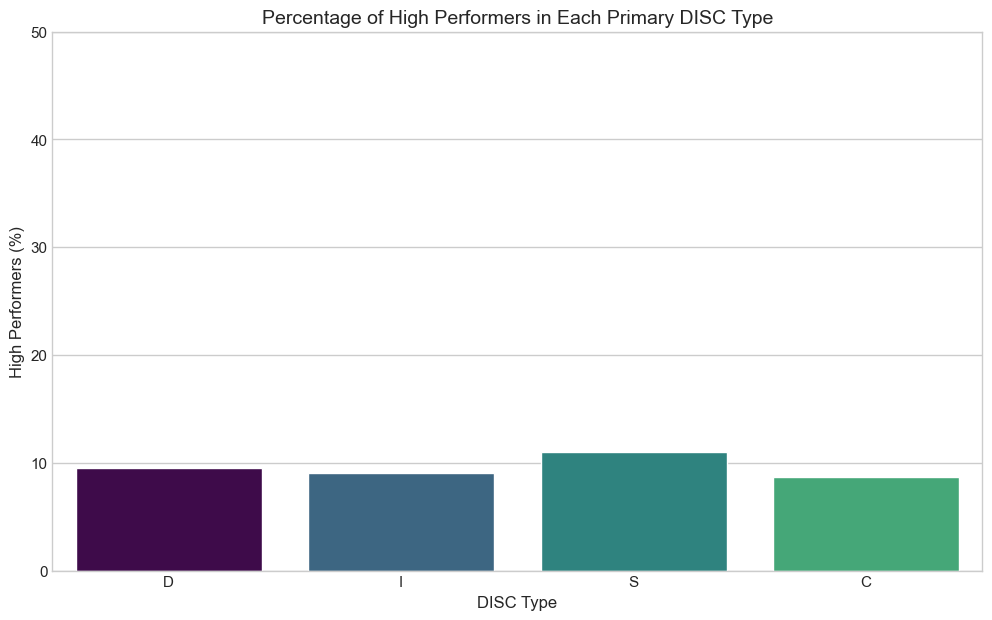

In [5]:
def plot_psychometric_analysis(df):
    """Menganalisis korelasi dan distribusi profil psikometrik."""
    
    # --- Heatmap Korelasi ---
    plt.figure(figsize=(8, 10))
    corr_cols = ['latest_rating', 'iq', 'gtq',
                 'papi_n_score', 'papi_l_score', 'papi_p_score', 'papi_a_score']
    
    correlation_matrix = df[corr_cols].corr()[['latest_rating']].sort_values(by='latest_rating', ascending=False)
    
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", vmin=-0.3, vmax=0.3)
    plt.title('Correlation Between Psychometric & Latest Rating', fontsize=14)
    plt.show()

    # --- Analisis Proporsi DISC ---
    plt.figure(figsize=(12, 7))
    # Ambil hanya karakter pertama dari DISC (D, I, S, atau C)
    df['disc_primary'] = df['disc'].str[0]
    
    # Hitung proporsi High Performers dalam setiap kategori DISC utama
    disc_prop = df.groupby('disc_primary')['performance_group'].value_counts(normalize=True).mul(100)
    disc_prop = disc_prop.rename('percentage').reset_index()

    sns.barplot(data=disc_prop[disc_prop['performance_group'] == 'High Performer'],
                x='disc_primary', y='percentage', order=['D', 'I', 'S', 'C'], palette=['#440154', '#31688e', '#21918c', '#35b779'])
    
    plt.title('Percentage of High Performers in Each Primary DISC Type', fontsize=14)
    plt.xlabel('DISC Type')
    plt.ylabel('High Performers (%)')
    plt.ylim(0, 50) # Set limit untuk perbandingan yang lebih baik
    plt.show()

plot_psychometric_analysis(df)

C:\Users\backup\AppData\Local\Temp\ipykernel_3476\483351726.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_prop = df.groupby('service_years_bin')['performance_group'].value_counts(normalize=True).mul(100)


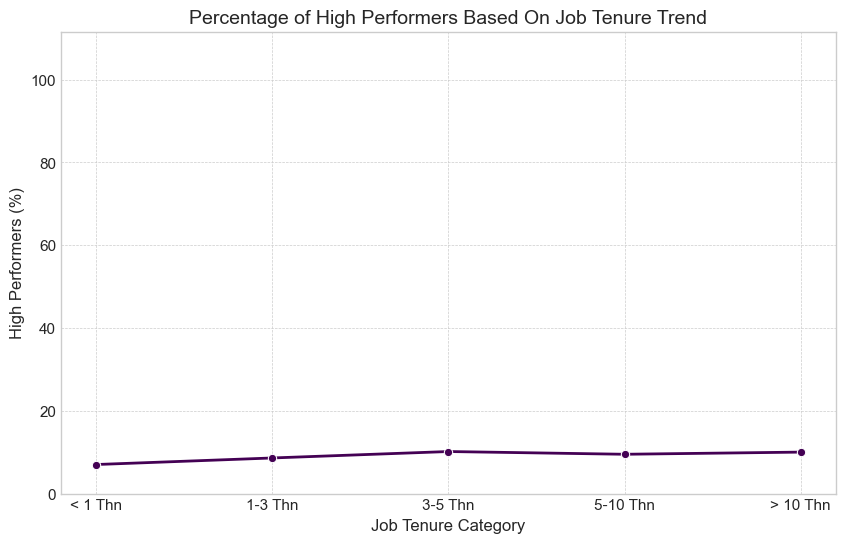

In [6]:
def plot_contextual_factors(df):
    """Menganalisis pengaruh masa kerja dan jenjang terhadap kinerja."""
    
    # --- Analisis Masa Kerja ---
    # Buat kategori (bin) untuk masa kerja
    bins = [0, 12, 36, 60, 120, df['years_of_service_months'].max() + 1]
    labels = ['< 1 Thn', '1-3 Thn', '3-5 Thn', '5-10 Thn', '> 10 Thn']
    df['service_years_bin'] = pd.cut(df['years_of_service_months'], bins=bins, labels=labels, right=False)
    
    # Hitung proporsi High Performers per kategori masa kerja
    service_prop = df.groupby('service_years_bin')['performance_group'].value_counts(normalize=True).mul(100)
    service_prop = service_prop.rename('percentage').reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=service_prop[service_prop['performance_group'] == 'High Performer'],
                 x='service_years_bin', y='percentage', sort=False, marker='o', color='#440154', lw=2)
    
    plt.title('Percentage of High Performers Based On Job Tenure Trend', fontsize=14)
    plt.xlabel('Job Tenure Category')
    plt.ylabel('High Performers (%)')
    plt.ylim(0, max(service_prop['percentage']) * 1.2)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_contextual_factors(df)


Data frekuensi kekuatan berhasil ditarik.
Membuat visualisasi perbandingan CliftonStrengths...


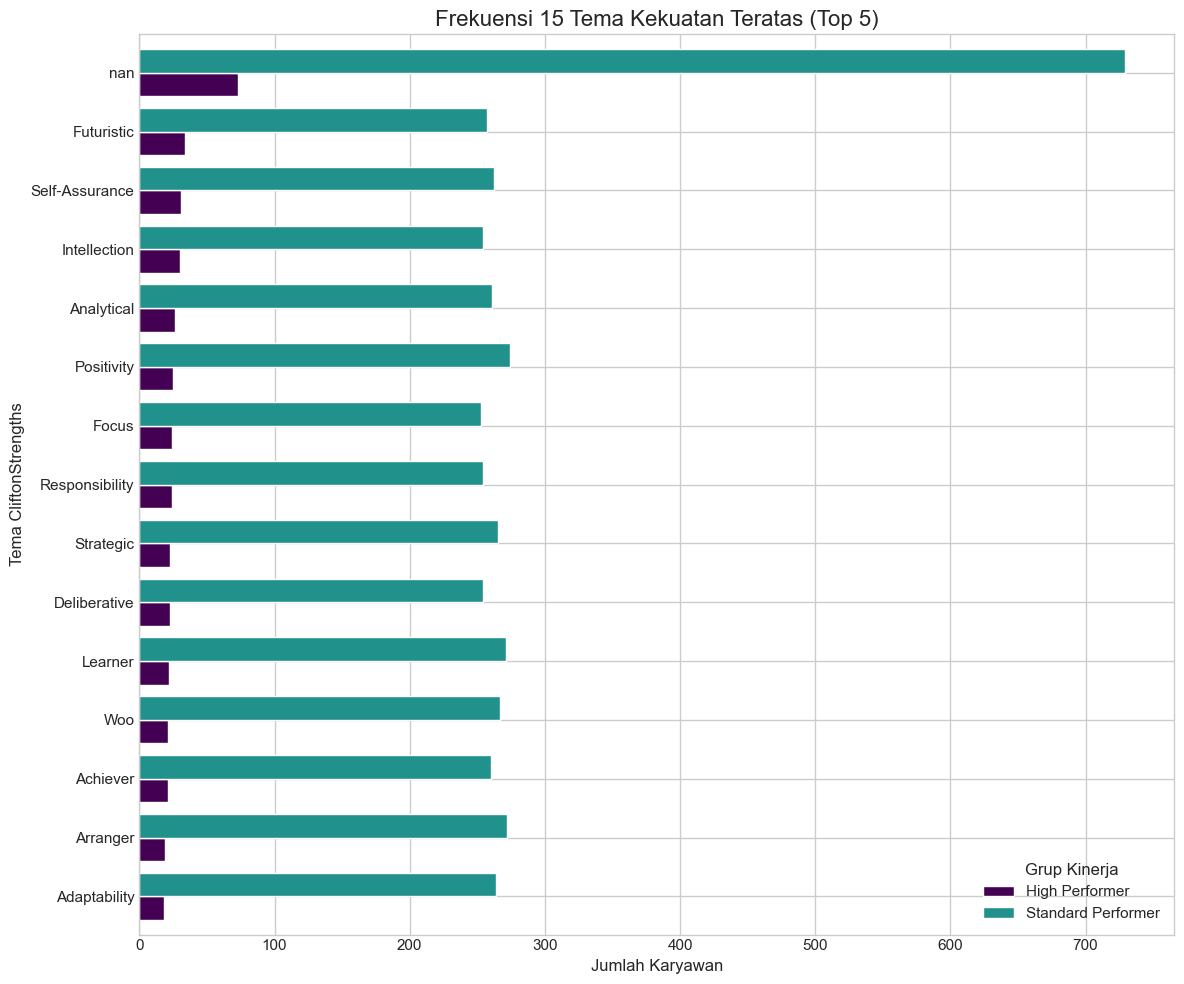

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_strengths = pd.read_csv('avg_strengths.csv')
print("\nData frekuensi kekuatan berhasil ditarik.")

# --- Visualisasi Perbandingan Tema Kekuatan ---
def plot_strengths_comparison(df_strengths):
    """Membuat bar chart untuk membandingkan tema kekuatan yang paling membedakan."""
    print("Membuat visualisasi perbandingan CliftonStrengths...")
    
    # Pivot data agar mudah di-plot
    df_pivot = df_strengths.pivot(index='theme', columns='performance_group', values='theme_count').fillna(0)
    
    # Hitung total kemunculan untuk sorting
    df_pivot['total'] = df_pivot['High Performer'] + df_pivot['Standard Performer']
    
    # Ambil 15 tema paling umum untuk menjaga kejelasan plot
    top_themes = df_pivot.sort_values('total', ascending=False).head(15)
    
    # Plotting
    top_themes[['High Performer', 'Standard Performer']].sort_values(by='High Performer', ascending=True).plot(
        kind='barh', # Horizontal bar chart
        figsize=(12, 10),
        color={'High Performer': '#440154', 'Standard Performer': '#21918c'},
        width=0.8
    )
    
    plt.title('Frekuensi 15 Tema Kekuatan Teratas (Top 5)', fontsize=16)
    plt.xlabel('Jumlah Karyawan', fontsize=12)
    plt.ylabel('Tema CliftonStrengths', fontsize=12)
    plt.legend(title='Grup Kinerja')
    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi

plot_strengths_comparison(df_strengths)


Data rata-rata peringkat per tema:
                domain           theme  High Performer  Standard Performer  \
8            Executing     Restorative        6.430769            7.777778   
9          Influencing       Activator        6.781250            7.752149   
0            Executing        Achiever        6.553846            7.513067   
14         Influencing  Self-Assurance        6.652174            7.585927   
27  Strategic Thinking      Futuristic        6.910256            7.512931   

        diff  
8   1.347009  
9   0.970899  
0   0.959221  
14  0.933753  
27  0.602675  

Membuat visualisasi perbandingan peringkat rata-rata CliftonStrengths...


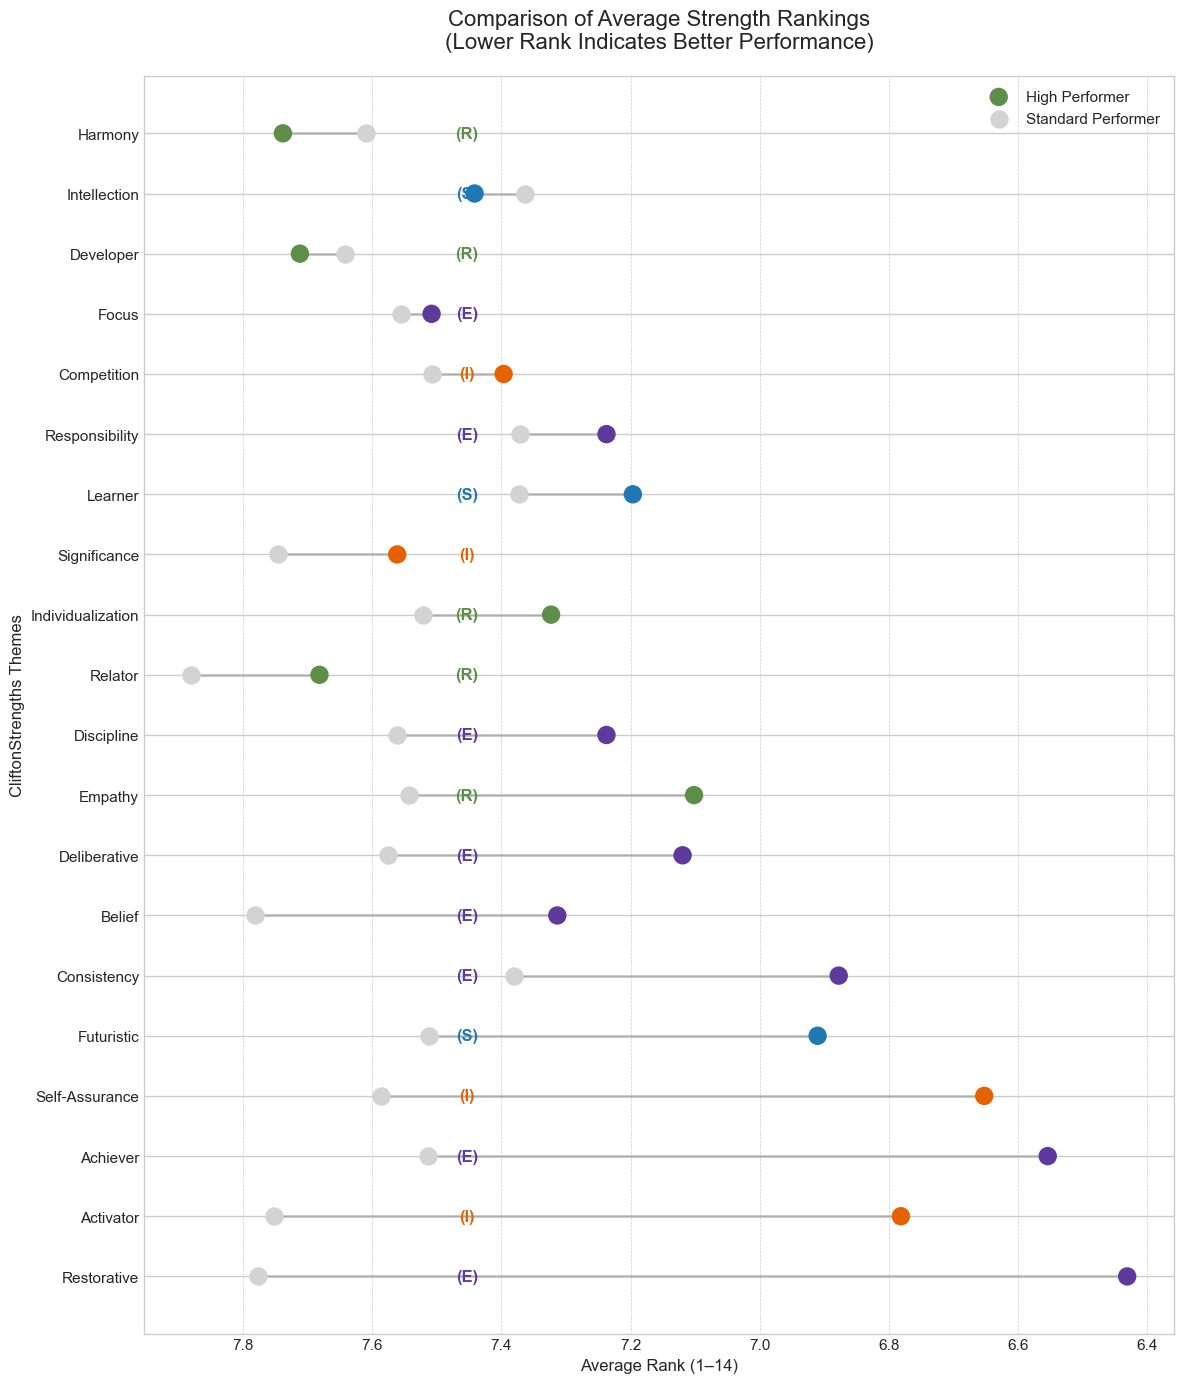

In [8]:
# --- 1. Definisi Domain Kekuatan ---
strength_domains = {
    'Executing': ['Achiever', 'Arranger', 'Belief', 'Consistency', 'Deliberative', 'Discipline', 'Focus', 'Responsibility', 'Restorative'],
    'Influencing': ['Activator', 'Command', 'Communication', 'Competition', 'Maximizer', 'Self-Assurance', 'Significance', 'Woo'],
    'Relationship Building': ['Adaptability', 'Connectedness', 'Developer', 'Empathy', 'Harmony', 'Includer', 'Individualization', 'Relator'],
    'Strategic Thinking': ['Analytical', 'Context', 'Futuristic', 'Ideation', 'Input', 'Intellection', 'Learner', 'Strategic']
}

# Membuat DataFrame dari dictionary di atas untuk join
domain_map_list = []
for domain, themes in strength_domains.items():
    for theme in themes:
        domain_map_list.append({'theme': theme, 'domain': domain})
df_domain_map = pd.DataFrame(domain_map_list)

df_ranks = pd.read_csv('avg_strengths.csv')
# --- 3. Proses & Agregasi Data ---
# Gabungkan dengan domain
df_ranks_with_domain = pd.merge(df_ranks, df_domain_map, on='theme')

# Hitung rata-rata peringkat per tema dan grup
avg_ranks = df_ranks_with_domain.groupby(['domain', 'theme', 'performance_group'])['rank'].mean().unstack().reset_index()
avg_ranks.columns.name = None # Hapus nama kolom indeks

# Hitung perbedaan untuk sorting
avg_ranks['diff'] = avg_ranks['Standard Performer'] - avg_ranks['High Performer']
avg_ranks = avg_ranks.sort_values('diff', ascending=False)
print("\nData rata-rata peringkat per tema:")
print(avg_ranks.head())

# --- 4. Visualisasi (Dumbbell Plot) ---
def plot_strength_rank_comparison(df):
    """Membuat dumbbell plot untuk membandingkan rata-rata peringkat kekuatan."""
    print("\nMembuat visualisasi perbandingan peringkat rata-rata CliftonStrengths...")
    
    # Filter untuk 20 tema dengan perbedaan terbesar agar plot tidak terlalu padat
    df_plot = df.nlargest(20, 'diff').sort_values('diff')

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 14))

    # Membuat garis horizontal (dumbbell bar)
    ax.hlines(y=df_plot['theme'], xmin=df_plot['High Performer'], xmax=df_plot['Standard Performer'],
              color='grey', alpha=0.4, linewidth=2)

    # Membuat titik untuk setiap grup
    domain_colors = {'Executing': '#5d3a9b', 'Influencing': '#e66100', 'Relationship Building': '#5e8f49', 'Strategic Thinking': '#1f78b4'}
    colors = df_plot['domain'].map(domain_colors)
    
    ax.scatter(df_plot['High Performer'], df_plot['theme'], color=colors, s=150, label='High Performer', zorder=3)
    ax.scatter(df_plot['Standard Performer'], df_plot['theme'], color='lightgrey', s=150, label='Standard Performer', zorder=3)
    
    # Kustomisasi Plot
    ax.set_title('Comparison of Average Strength Rankings\n(Lower Rank Indicates Better Performance)', fontsize=16, pad=20)
    ax.set_xlabel('Average Rank (1–14)', fontsize=12)
    ax.set_ylabel('CliftonStrengths Themes', fontsize=12)
    ax.legend()

    
    # Invert y-axis agar tema dengan perbedaan terbesar ada di atas
    ax.invert_yaxis()
    # Invert x-axis agar peringkat rendah (baik) ada di kiri
    ax.invert_xaxis()
    ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

    # Tambahkan label domain di samping y-axis
    for i, row in df_plot.iterrows():
        ax.text(ax.get_xlim()[0] - 0.5, row['theme'], f"({row['domain'][0]})",
                va='center', ha='center', color=domain_colors[row['domain']], weight='bold')

    plt.tight_layout()
    plt.show()

plot_strength_rank_comparison(avg_ranks)